In [3]:
#from keras_dna import Generator, ModelWrapper
import tensorflow.keras as keras
import numpy as np
#import pyBigWig
import h5py
#import pandas as pd
#import matplotlib.pyplot as plt
import itertools

In [2]:
from MyModuleLibrary.mykeras.losses import mae_cor, correlate
from MyModuleLibrary.array_modifier import rolling_window

In [3]:
def one_hot_encoder(nucleotid):
    res = (np.arange(4) == nucleotid[..., None]-1).astype(int)
    res = res.reshape(res.shape[0], 4)
    return res

In [4]:
import matplotlib 
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16)

# Predictions

In [27]:
model = keras.models.load_model('./models/weights_myco_pol2_2048_16_3.hdf5', custom_objects={'correlate' : correlate})

generator_train = Generator(batch_size=64,
                            fasta_file='./data/W303.fa',
                            annotation_files=['../Projet_cohesine/data/myco_coverage_rep1.bw'],
                            size='./data/sacCer3.chrom.sizes',
                            window=2048,
                            tg_window=16,
                            downsampling='mean',
                            overlapping=10,
                            normalization_mode='max',
                            weighting_mode=([[-0.2, 0.1, 0.2, 0.3, 0.5, 0.6, 0.8, 1.0]],
                                            [[1, 4, 10, 20, 30, 40, 50]]),
                            incl_chromosomes=['chr01'],
                            output_shape=(64, 16, 1))

wrap = ModelWrapper(model=model,
                    generator_train=generator_train,
                    validation_chr=['chr15', 'chr16'],
                    weights_val=True)

wrap.predict(incl_chromosomes=['chr01', 'chr02', 'chr03', 'chr04',
                               'chr05', 'chr06', 'chr07', 'chr08', 'chr09', 'chr10',
                               'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16'],
             chrom_size='./data/W303.chrom.sizes',
             export_to_path='./results/yeast/pol2_myco_2048_16_3')

array([[[1.2490281 ],
        [1.1919239 ],
        [1.2410741 ],
        ...,
        [0.61264664],
        [0.71926033],
        [0.8626843 ]],

       [[0.6530956 ],
        [0.5448974 ],
        [0.37927485],
        ...,
        [0.18061483],
        [0.16343713],
        [0.36809266]],

       [[0.2547493 ],
        [0.1986283 ],
        [0.15178752],
        ...,
        [0.17769134],
        [0.23212492],
        [0.17119312]],

       ...,

       [[0.5835761 ],
        [0.50593746],
        [0.65671647],
        ...,
        [0.37354296],
        [0.46352363],
        [0.40741962]],

       [[1.0698513 ],
        [1.2111526 ],
        [1.0264091 ],
        ...,
        [0.38193423],
        [0.38878447],
        [0.36373293]],

       [[0.4373269 ],
        [0.4282757 ],
        [0.42285872],
        ...,
        [1.0780786 ],
        [0.96448904],
        [1.2702085 ]]], dtype=float32)

In [6]:
model = keras.models.load_model('./models/weights_gal_pol2_CNN2000.hdf5', custom_objects={'correlate' : correlate})

generator_train = Generator(batch_size=64,
                            fasta_file='./data/W303.fa',
                            annotation_files=['./data/pneumo_coverage_pol2_log_cpm.bw'],
                            size='./data/W303.chrom.sizes',
                            window=2000,
                            tg_window=1,
                            weighting_mode=([[0, 1, 2, 3, 4, 5, 6, 10]],
                                            [[1, 4, 10, 20, 30, 40, 50]]),
                            incl_chromosomes=['chr01', 'chr02', 'chr03', 'chr04',
                                              'chr05', 'chr06', 'chr07', 'chr08', 'chr09', 'chr10',
                                              'chr11', 'chr12', 'chr13', 'chr14'],
                            output_shape=(64, 1))

wrap = ModelWrapper(model=model,
                    generator_train=generator_train,
                    validation_chr=['chr15', 'chr16'],
                    weights_val=True)

wrap.predict(incl_chromosomes=['chr01', 'chr02', 'chr03', 'chr04',
                               'chr05', 'chr06', 'chr07', 'chr08', 'chr09', 'chr10',
                               'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16'],
             chrom_size='./data/W303.chrom.sizes',
             export_to_path='./results/yeast/pol2_gal')

Instructions for updating:
Please use Model.predict, which supports generators.


KeyboardInterrupt: 

In [8]:
WINDOW = 2048

In [29]:
def prepare_input(pathname):
    seq_chr = np.array(h5py.File(pathname, 'r')['data'])[:, 0]
    
    if len(seq_chr) < WINDOW:
        padding = (WINDOW - len(seq_chr)) // 2
        adder = (len(seq_chr) - WINDOW) % 2
        seq_chr = np.concatenate([np.zeros(padding), seq_chr, np.zeros(padding + adder)])
        print(len(seq_chr))
        
    seq_chr[seq_chr == 2] = 5
    seq_chr[seq_chr == 4] = 2
    seq_chr[seq_chr == 5] = 4
    seq_chr_onehot = one_hot_encoder(seq_chr)
    X = rolling_window(seq_chr_onehot, (WINDOW, 4), (WINDOW, 4))[:, 0, :, :]
    return X

In [30]:
y_pred = model.predict(prepare_input('./data/bacterie/Mmm_Linear_740kb.hdf5'))
prediction = np.zeros((1222199,))
y_pred = np.concatenate([np.concatenate(pred) for pred in np.tile(y_pred, [1, 1, 128])])
prediction[:len(y_pred)] = y_pred
np.save('./results/bacterial/pol2_myco_2048_16_3.npy', prediction)

In [31]:
y_pred = model.predict(prepare_input('./data/bacterie/Pneu300.hdf5'))
prediction = np.zeros((817946,))
y_pred = np.concatenate([np.concatenate(pred) for pred in np.tile(y_pred, [1, 1, 128])])
prediction[:len(y_pred)] = y_pred
np.save('./results/bacterial/pol2_pneu_2048_16_3.npy', prediction)

# Représentation sur l'ensemble du génome

In [14]:
yeast_sizes = pd.read_csv('./data/W303.chrom.sizes', sep='\t', names=['chr', 'size'])
yeast_sizes = {chrom : size for chrom, size in yeast_sizes.values}

myco_sizes = pd.read_csv('./data/bacterie/Mmm_Linear_740kb.chrom.sizes', sep='\t', names=['chr', 'size'])
myco_sizes = {chrom : size for chrom, size in myco_sizes.values}

pneu_sizes = pd.read_csv('./data/bacterie/Pneu300.chrom.sizes', sep='\t', names=['chr', 'size'])
pneu_sizes = {chrom : size for chrom, size in pneu_sizes.values}

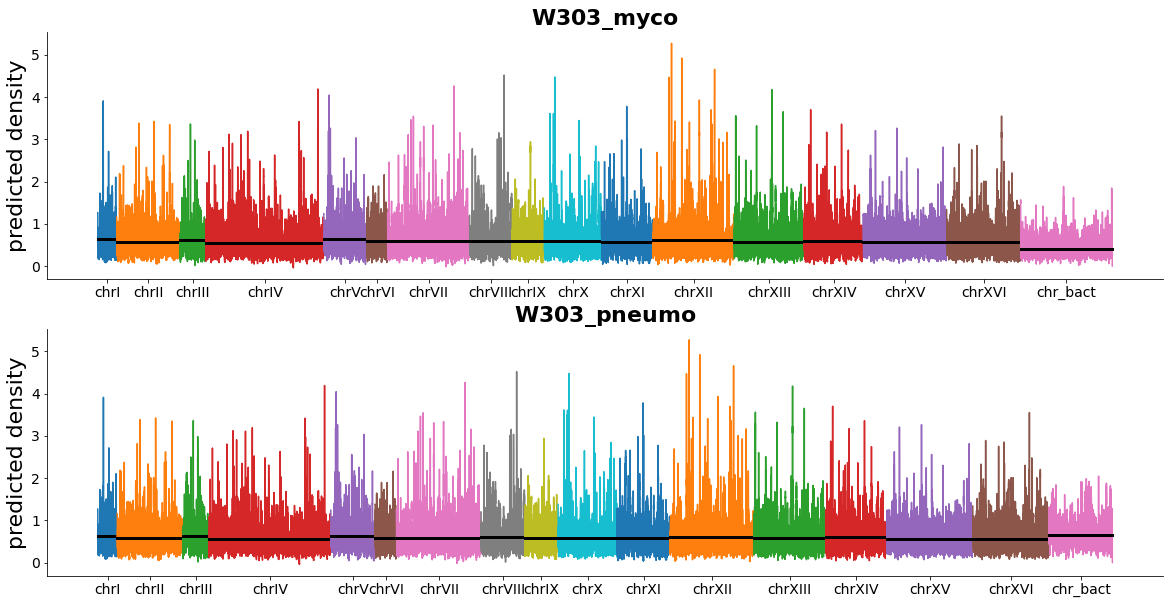

In [159]:
fig = plt.figure(figsize=(20, 10))

ax = fig.add_subplot(2, 1, 1)
start = 0
stop = 0
xticks = []


bw = pyBigWig.open("./results/yeast/pol2_myco_2048_16_cell_number0_annotation_number0.bw")

for chrom in ['chr01', 'chr02', 'chr03', 'chr04',
              'chr05', 'chr06', 'chr07', 'chr08', 'chr09', 'chr10',
              'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16']:
    
    prediction = np.array(bw.values(chrom, 0, yeast_sizes[chrom]))
    stop += len(prediction)
    xticks.append((stop + start) // 2)
    ax.plot(np.arange(start, stop), prediction)
    prediction[np.isnan(prediction)] = 0
    ax.plot([start, stop], [np.mean(prediction), np.mean(prediction)], 'k', linewidth=3)
    start += len(prediction)

bw.close()

prediction = np.load('./results/bacterial/pol2_myco_2048_16.npy')
stop += len(prediction)
xticks.append((stop + start) // 2)
ax.plot(np.arange(start, stop), prediction)
ax.plot([start, stop], [np.mean(prediction), np.mean(prediction)], 'k', linewidth=3)
start += len(prediction)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(xticks)
ax.set_xticklabels(['chrI', 'chrII', 'chrIII', 'chrIV', 'chrV', 'chrVI', 'chrVII', 'chrVIII', 'chrIX',
                    'chrX', 'chrXI', 'chrXII', 'chrXIII', 'chrXIV', 'chrXV', 'chrXVI', 'chr_bact'])
ax.set_title(r'$\bf{W303\_myco}$', fontsize=22)
ax.set_ylabel('predicted density', fontsize=22)
#ax.set_ylim([0, 0.01])

ax = fig.add_subplot(2, 1, 2)
start = 0
stop = 0
xticks = []

bw = pyBigWig.open("./results/yeast/pol2_myco_2048_16_cell_number0_annotation_number0.bw")

for chrom in ['chr01', 'chr02', 'chr03', 'chr04',
              'chr05', 'chr06', 'chr07', 'chr08', 'chr09', 'chr10',
              'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16']:

    prediction = np.array(bw.values(chrom, 0, yeast_sizes[chrom]))
    stop += len(prediction)
    xticks.append((stop + start) // 2)
    ax.plot(np.arange(start, stop), prediction)
    prediction[np.isnan(prediction)] = 0
    ax.plot([start, stop], [np.mean(prediction), np.mean(prediction)], 'k', linewidth=3)
    start += len(prediction)

bw.close()

prediction = np.load('./results/bacterial/pol2_pneu_2048_16.npy')
stop += len(prediction)
xticks.append((stop + start) // 2)
ax.plot(np.arange(start, stop), prediction)
ax.plot([start, stop], [np.mean(prediction), np.mean(prediction)], 'k', linewidth=3)
start += len(prediction)
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(xticks)
ax.set_xticklabels(['chrI', 'chrII', 'chrIII', 'chrIV', 'chrV', 'chrVI', 'chrVII', 'chrVIII', 'chrIX',
                    'chrX', 'chrXI', 'chrXII', 'chrXIII', 'chrXIV', 'chrXV', 'chrXVI', 'chr_bact'])
ax.set_title(r'$\bf{W303\_pneumo}$', fontsize=22)
ax.set_ylabel('predicted density', fontsize=22)
#ax.set_ylim([0, 0.01])

fig.savefig('./results/pol2_2048_16_density.png')

In [21]:
myco_coverage_rep1 = read_bed('./data/for_Julien/myco/coverage_RPKM102.bed')
myco_coverage_rep2 = read_bed('./data/for_Julien/myco/coverage_RPKM105.bed')

pneu_coverage_rep1 = read_bed('./data/for_Julien/pneumo/coverage_RPKM154.bed')
pneu_coverage_rep2 = read_bed('./data/for_Julien/pneumo/coverage_RPKM155.bed')

In [ ]:
def log(x):
    x_ = np.copy(x)
    x_[np.isnan(x_)] = 0
    x_[np.isinf(x_)] = np.percentile(x_, 99.5)
    x_[np.isinf(x_)] = np.percentile(x_, 90)
    x_ = np.log2(x_ + 1)
    return x_

/users/invites/routhier/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/users/invites/routhier/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/users/invites/routhier/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/users/invites/routhier/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/users/invites/routhier/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/users/invites/routhier/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWar

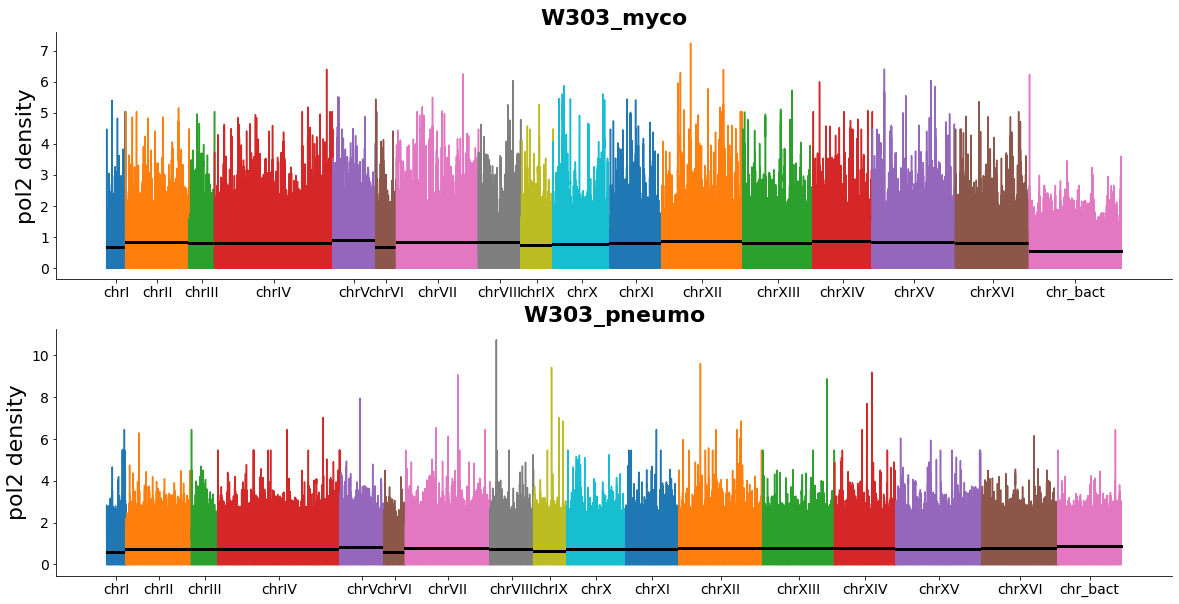

In [191]:
fig = plt.figure(figsize=(20, 10))

ax = fig.add_subplot(2, 1, 1)
start = 0
stop = 0
xticks = []

for chrom in ['chr01', 'chr02', 'chr03', 'chr04',
              'chr05', 'chr06', 'chr07', 'chr08', 'chr09', 'chr10',
              'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16',
              'Mmm_Linear_740kb.fa']:

    prediction = log(myco_coverage_rep1[chrom] / myco_coverage_rep2[chrom])
    stop += len(prediction)
    xticks.append((stop + start) // 2)
    ax.plot(np.arange(start, stop), prediction)
    ax.plot([start, stop], [np.mean(prediction), np.mean(prediction)], 'k', linewidth=3)
    start += len(prediction)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(xticks)
ax.set_xticklabels(['chrI', 'chrII', 'chrIII', 'chrIV', 'chrV', 'chrVI', 'chrVII', 'chrVIII', 'chrIX',
                    'chrX', 'chrXI', 'chrXII', 'chrXIII', 'chrXIV', 'chrXV', 'chrXVI', 'chr_bact'])
ax.set_title(r'$\bf{W303\_myco}$', fontsize=22)
ax.set_ylabel('pol2 density', fontsize=22)
#ax.set_ylim([-0.05, 1])

ax = fig.add_subplot(2, 1, 2)
start = 0
stop = 0
xticks = []

for chrom in ['chr01', 'chr02', 'chr03', 'chr04',
              'chr05', 'chr06', 'chr07', 'chr08', 'chr09', 'chr10',
              'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16',
              'Pneu300']:
    
    prediction = log(pneu_coverage_rep1[chrom] / pneu_coverage_rep2[chrom]) 
    stop += len(prediction)
    xticks.append((stop + start) // 2)
    ax.plot(np.arange(start, stop), prediction)
    ax.plot([start, stop], [np.mean(prediction), np.mean(prediction)], 'k', linewidth=3)
    start += len(prediction)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(xticks)
ax.set_xticklabels(['chrI', 'chrII', 'chrIII', 'chrIV', 'chrV', 'chrVI', 'chrVII', 'chrVIII', 'chrIX',
                    'chrX', 'chrXI', 'chrXII', 'chrXIII', 'chrXIV', 'chrXV', 'chrXVI', 'chr_bact'])
ax.set_title(r'$\bf{W303\_pneumo}$', fontsize=22)
ax.set_ylabel('pol2 density', fontsize=22)
#ax.set_ylim([-0.05, 1])

fig.savefig('./results/pol2_density_experimental.png')

## Reprise des figures

/users/invites/routhier/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/users/invites/routhier/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/users/invites/routhier/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/users/invites/routhier/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/users/invites/routhier/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as a

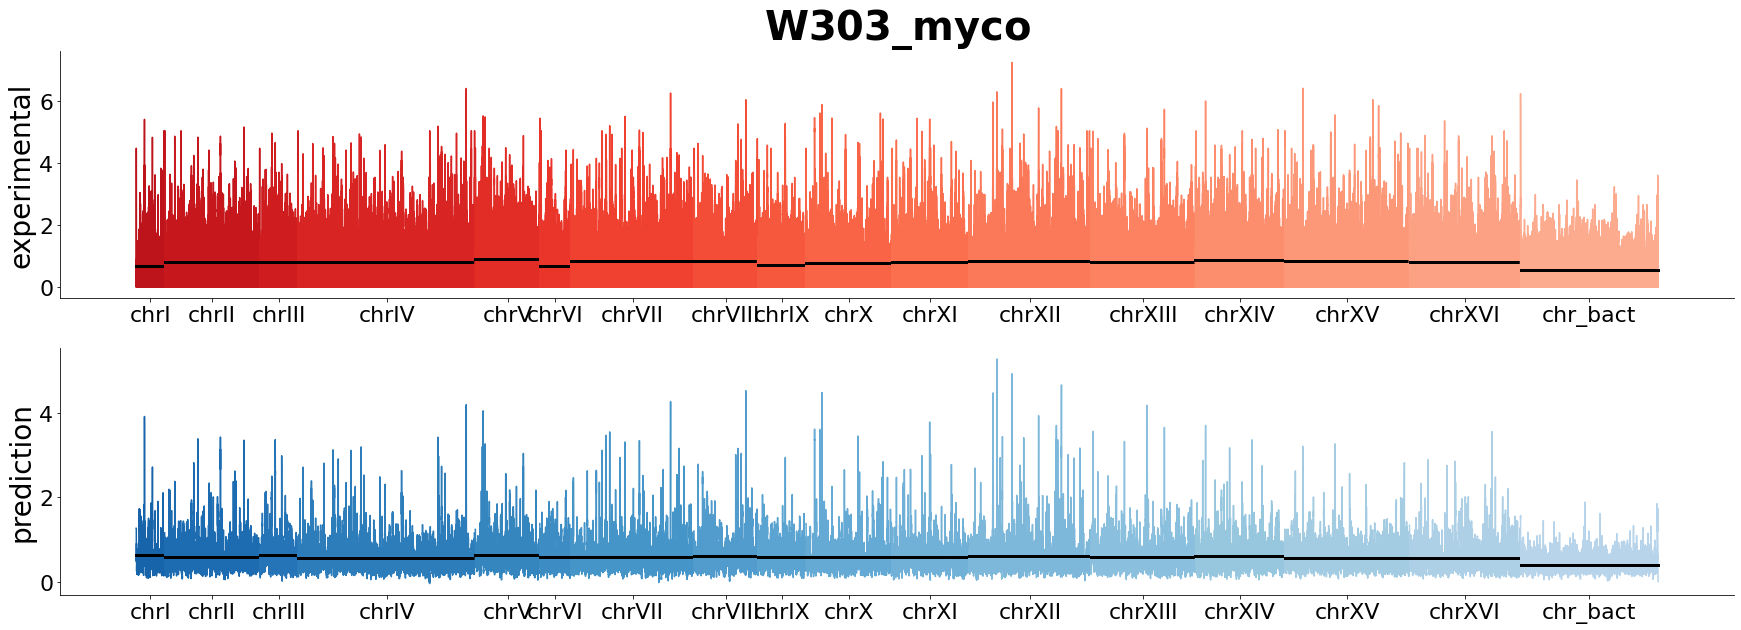

In [193]:
fig = plt.figure(figsize=(30, 10))

ax = fig.add_subplot(2, 1, 1)
start = 0
stop = 0
xticks = []

colors = plt.cm.Reds_r(np.linspace(0.2, 0.7, 17))

for i, chrom in enumerate(['chr01', 'chr02', 'chr03', 'chr04',
                          'chr05', 'chr06', 'chr07', 'chr08', 'chr09', 'chr10',
                          'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16',
                          'Mmm_Linear_740kb.fa']):

    prediction = log(myco_coverage_rep1[chrom] / myco_coverage_rep2[chrom])
    stop += len(prediction)
    xticks.append((stop + start) // 2)
    ax.plot(np.arange(start, stop), prediction, color=colors[i])
    ax.plot([start, stop], [np.mean(prediction), np.mean(prediction)], 'k', linewidth=3)
    start += len(prediction)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(xticks)
ax.set_xticklabels(['chrI', 'chrII', 'chrIII', 'chrIV', 'chrV', 'chrVI', 'chrVII', 'chrVIII', 'chrIX',
                    'chrX', 'chrXI', 'chrXII', 'chrXIII', 'chrXIV', 'chrXV', 'chrXVI', 'chr_bact'])
ax.set_title(r'$\bf{W303\_myco}$', fontsize=40)
ax.set_ylabel('experimental', fontsize=28)

ax = fig.add_subplot(2, 1, 2)
start = 0
stop = 0
xticks = []

bw = pyBigWig.open("./results/yeast/pol2_myco_2048_16_cell_number0_annotation_number0.bw")
colors = plt.cm.Blues_r(np.linspace(0.2, 0.7, 17))

for i, chrom in enumerate(['chr01', 'chr02', 'chr03', 'chr04',
                           'chr05', 'chr06', 'chr07', 'chr08', 'chr09', 'chr10',
                           'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16']):

    prediction = np.array(bw.values(chrom, 0, yeast_sizes[chrom]))
    stop += len(prediction)
    xticks.append((stop + start) // 2)
    ax.plot(np.arange(start, stop), prediction, color=colors[i])
    prediction[np.isnan(prediction)] = 0
    ax.plot([start, stop], [np.mean(prediction), np.mean(prediction)], 'k', linewidth=3)
    start += len(prediction)

bw.close()

prediction = np.load('./results/bacterial/pol2_myco_2048_16.npy')
stop += len(prediction)
xticks.append((stop + start) // 2)
ax.plot(np.arange(start, stop), prediction, color=colors[-1])
ax.plot([start, stop], [np.mean(prediction), np.mean(prediction)], 'k', linewidth=3)
start += len(prediction)
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(xticks)
ax.set_xticklabels(['chrI', 'chrII', 'chrIII', 'chrIV', 'chrV', 'chrVI', 'chrVII', 'chrVIII', 'chrIX',
                    'chrX', 'chrXI', 'chrXII', 'chrXIII', 'chrXIV', 'chrXV', 'chrXVI', 'chr_bact'])
ax.set_ylabel('prediction', fontsize=28)

fig.savefig('./results/pol2_myco_whole_genome.png')

/users/invites/routhier/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/users/invites/routhier/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/users/invites/routhier/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/users/invites/routhier/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/users/invites/routhier/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as a

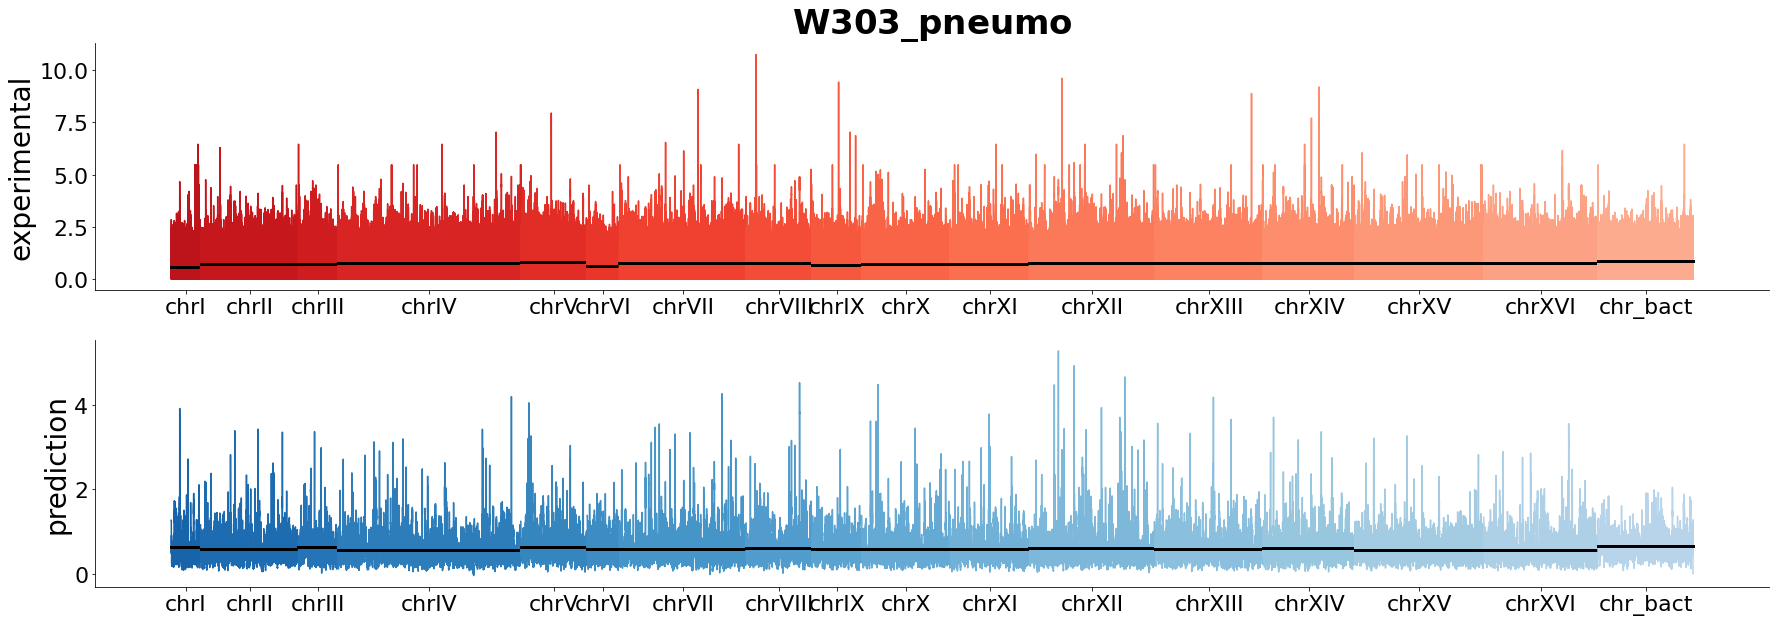

In [195]:
fig = plt.figure(figsize=(30, 10))

ax = fig.add_subplot(2, 1, 1)
start = 0
stop = 0
xticks = []

colors = plt.cm.Reds_r(np.linspace(0.2, 0.7, 17))

for i, chrom in enumerate(['chr01', 'chr02', 'chr03', 'chr04',
                          'chr05', 'chr06', 'chr07', 'chr08', 'chr09', 'chr10',
                          'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16',
                          'Pneu300']):

    prediction = log(pneu_coverage_rep1[chrom] / pneu_coverage_rep2[chrom])
    stop += len(prediction)
    xticks.append((stop + start) // 2)
    ax.plot(np.arange(start, stop), prediction, color=colors[i])
    ax.plot([start, stop], [np.mean(prediction), np.mean(prediction)], 'k', linewidth=3)
    start += len(prediction)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(xticks)
ax.set_xticklabels(['chrI', 'chrII', 'chrIII', 'chrIV', 'chrV', 'chrVI', 'chrVII', 'chrVIII', 'chrIX',
                    'chrX', 'chrXI', 'chrXII', 'chrXIII', 'chrXIV', 'chrXV', 'chrXVI', 'chr_bact'])
ax.set_title(r'$\bf{W303\_pneumo}$', fontsize=34)
ax.set_ylabel('experimental', fontsize=28)

ax = fig.add_subplot(2, 1, 2)
start = 0
stop = 0
xticks = []

bw = pyBigWig.open("./results/yeast/pol2_myco_2048_16_cell_number0_annotation_number0.bw")
colors = plt.cm.Blues_r(np.linspace(0.2, 0.7, 17))

for i, chrom in enumerate(['chr01', 'chr02', 'chr03', 'chr04',
                           'chr05', 'chr06', 'chr07', 'chr08', 'chr09', 'chr10',
                           'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16']):

    prediction = np.array(bw.values(chrom, 0, yeast_sizes[chrom]))
    stop += len(prediction)
    xticks.append((stop + start) // 2)
    ax.plot(np.arange(start, stop), prediction, color=colors[i])
    prediction[np.isnan(prediction)] = 0
    ax.plot([start, stop], [np.mean(prediction), np.mean(prediction)], 'k', linewidth=3)
    start += len(prediction)

bw.close()

prediction = np.load('./results/bacterial/pol2_pneu_2048_16.npy')
stop += len(prediction)
xticks.append((stop + start) // 2)
ax.plot(np.arange(start, stop), prediction, color=colors[-1])
ax.plot([start, stop], [np.mean(prediction), np.mean(prediction)], 'k', linewidth=3)
start += len(prediction)
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(xticks)
ax.set_xticklabels(['chrI', 'chrII', 'chrIII', 'chrIV', 'chrV', 'chrVI', 'chrVII', 'chrVIII', 'chrIX',
                    'chrX', 'chrXI', 'chrXII', 'chrXIII', 'chrXIV', 'chrXV', 'chrXVI', 'chr_bact'])
ax.set_ylabel('prediction', fontsize=28)

fig.savefig('./results/pol2_pneu_whole_genome.png')

# Comparison avec les données expérimentales

In [100]:
roman_to_num = {'chrI' : 'chr01', 'chrII' : 'chr02', 'chrIII' : 'chr03', 'chrIV' : 'chr04', 'chrV' : 'chr05',
                'chrVI' : 'chr06', 'chrVII' : 'chr07', 'chrVIII' : 'chr08', 'chrIX' : 'chr09', 'chrX' : 'chr10', 'chrXI' : 'chr11',
                'chrXII' : 'chr12', 'chrXIII' : 'chr13', 'chrXIV' : 'chr14', 'chrXV' : 'chr15', 'chrXVI' : 'chr16', 'chrM' : 'chrM'} 

In [20]:
chrom_size = pd.read_csv('./data/W303.chrom.sizes', sep='\t', names=['chrom', 'sizes'])
chrom_size = {chrom : size for chrom, size in zip(chrom_size.chrom.values, chrom_size.sizes.values)}
chrom_size['Mmm_Linear_740kb.fa'] = 1222199
chrom_size['Pneu300'] = 817946

### Préparation des données normalisées

In [18]:
def read_bed(pathname):
    df = pd.read_csv(pathname, names=['chrom', 'start', 'stop', 'density'], sep='\t')
    coverages = dict()
    for chrom in df.chrom.unique():
        if chrom in chrom_size:
            local_df = df[df.chrom == chrom]
            coverage = np.zeros(chrom_size[chrom])
            
            for start, stop, density in zip(local_df.start.values, local_df.stop.values, local_df.density.values):
                coverage[start : stop] = density
            coverages[chrom] = coverage
    
    all_coverage = np.concatenate([coverage for _, coverage in coverages.items()])
    threshold = np.sum(all_coverage) / 1000000.
    
    for chrom, coverage in coverages.items():
        coverages[chrom] = coverage / threshold
    return coverages

### Myco

In [107]:
num_to_roman = {value : key for key, value in roman_to_num.items()}

In [202]:
prediction = np.load('./results/bacterial/pol2_myco_2048_16.npy')

/users/invites/routhier/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
/users/invites/routhier/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


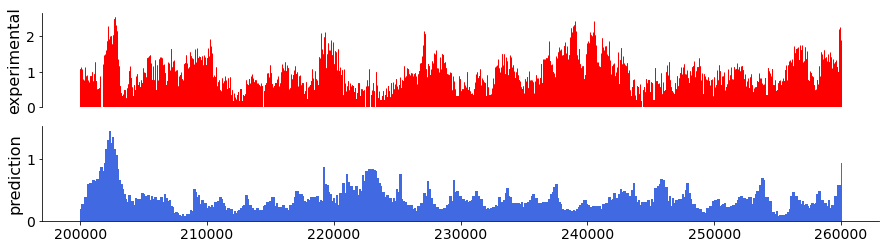

In [177]:
fig = plt.figure(figsize=(15, 8))

ax = fig.add_subplot(4, 1, 2)
start = 200000
stop = 260000

#ax.set_ylim([0, 1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.plot(np.arange(start, stop), prediction[start : stop], color='royalblue')
ax.bar(x=np.arange(start, stop), height=prediction[start : stop], width=1, edgecolor='royalblue')
ax.set_facecolor('w')
#ax.set_xticks(np.arange(start, stop + 1, 10000))
#ax.set_xticklabels(np.arange(start, stop + 1, 10000), fontsize=14)
#ax.set_yticks(np.arange(0, 1.1, 0.5))
#ax.set_yticklabels(np.arange(0, 1.1, 0.5), fontsize=14)
ax.set_ylabel('prediction', fontsize=16)
experimental = log(myco_coverage_rep1['Mmm_Linear_740kb.fa'] / myco_coverage_rep2['Mmm_Linear_740kb.fa'])
ax.text(x=start,
        y=2.5,
        s='correlation: {}'.format(np.round(np.corrcoef(experimental, prediction)[0, 1], 2)),
        fontsize=16)


ax1 = fig.add_subplot(4, 1, 1)
#ax1.set_ylim([0, 1])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.set_xticks([])
ax1.set_xticklabels([])
#ax1.set_yticks(np.arange(0, 1.1, 0.5))
#ax1.set_yticklabels(np.arange(0, 1.1, 0.5), fontsize=14)
#ax1.plot(np.arange(start, stop), experimental[start : stop], color='r')
ax1.bar(x=np.arange(start, stop), height=experimental[start : stop], width=1, edgecolor='r')
ax1.set_facecolor('w') 
ax1.set_ylabel('experimental', fontsize=16)

fig.savefig('./results/pol2_2048_16_exp_vs_pred_myco_rep1.png')

/users/invites/routhier/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide
/users/invites/routhier/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


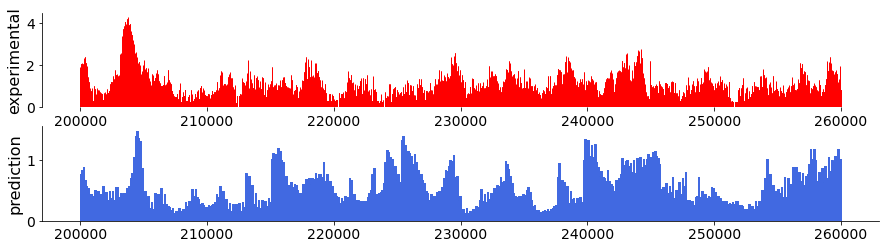

In [178]:
bw = pyBigWig.open("./results/yeast/pol2_myco_2048_16_cell_number0_annotation_number0.bw")
prediction = np.array(bw.values('chr16', 0, yeast_sizes['chr16']))
prediction[np.isnan(prediction)] = 0
bw.close()

fig = plt.figure(figsize=(15, 8))

ax = fig.add_subplot(4, 1, 2)
start = 200000
stop = 260000

#ax.set_ylim([0, 1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.plot(np.arange(start, stop), prediction[start : stop], color='royalblue')
ax.bar(x=np.arange(start, stop), height=prediction[start : stop], width=1, edgecolor='royalblue')
ax.set_facecolor('w')
#ax.set_xticks(np.arange(start, stop + 1, 10000))
#ax.set_xticklabels(np.arange(start, stop + 1, 10000), fontsize=14)
#ax.set_yticks(np.arange(0, 1.1, 0.5))
#ax.set_yticklabels(np.arange(0, 1.1, 0.5), fontsize=14)
ax.set_ylabel('prediction', fontsize=16)
experimental = log(myco_coverage_rep1['chr16'] / myco_coverage_rep2['chr16'])
ax.text(x=start,
        y=2.5,
        s='correlation: {}'.format(np.round(np.corrcoef(experimental, prediction)[0, 1], 2)),
        fontsize=16)

ax1 = fig.add_subplot(4, 1, 1)
#ax1.set_ylim([0, 1])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
#ax1.set_xticks([])
#ax1.set_xticklabels([])
#ax1.set_yticks(np.arange(0, 1.1, 0.5))
#ax1.set_yticklabels(np.arange(0, 1.1, 0.5), fontsize=14)
#ax1.plot(np.arange(start, stop), experimental[start : stop], color='r')
ax1.bar(x=np.arange(start, stop), height=experimental[start : stop], width=1, edgecolor='r')
ax1.set_facecolor('w') 
ax1.set_ylabel('experimental', fontsize=16)

fig.savefig('./results/pol2_2048_16_exp_vs_pred_myco_rep1_chr16.png')

### Pneumo

In [199]:
prediction = np.load('./results/bacterial/pol2_pneu_2048_16.npy')

/users/invites/routhier/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


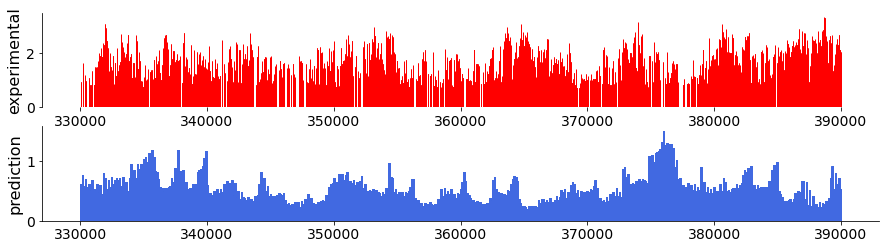

In [180]:
fig = plt.figure(figsize=(15, 8))

ax = fig.add_subplot(4, 1, 2)
start = 330000
stop = 390000

#ax.set_ylim([0, 1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.plot(np.arange(start, stop), prediction[start : stop], color='royalblue')
ax.bar(x=np.arange(start, stop), height=prediction[start : stop], width=1, edgecolor='royalblue')
ax.set_facecolor('w')
#ax.set_xticks(np.arange(start, stop + 1, 10000))
#ax.set_xticklabels(np.arange(start, stop + 1, 10000), fontsize=14)
#ax.set_yticks(np.arange(0, 1.1, 0.5))
#ax.set_yticklabels(np.arange(0, 1.1, 0.5), fontsize=14)
ax.set_ylabel('prediction', fontsize=16)
experimental = log(pneu_coverage_rep1['Pneu300'] / pneu_coverage_rep2['Pneu300'])
ax.text(x=start,
        y=2.5,
        s='correlation: {}'.format(np.round(np.corrcoef(experimental, prediction)[0, 1], 2)),
        fontsize=16)

ax1 = fig.add_subplot(4, 1, 1)
#ax1.set_ylim([0, 1])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
#ax1.set_xticks([])
#ax1.set_xticklabels([])
#ax1.set_yticks(np.arange(0, 1.1, 0.5))
#ax1.set_yticklabels(np.arange(0, 1.1, 0.5), fontsize=14)
#ax1.plot(np.arange(start, stop), experimental[start : stop], color='r')
ax1.bar(x=np.arange(start, stop), height=experimental[start : stop], width=1, edgecolor='r')
ax1.set_facecolor('w') 
ax1.set_ylabel('experimental', fontsize=16)

fig.savefig('./results/pol2_2048_16_exp_vs_pred_pneu_rep1.png')

/users/invites/routhier/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide
/users/invites/routhier/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


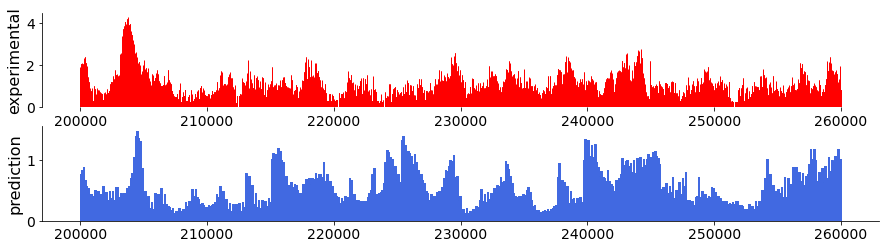

In [181]:
bw = pyBigWig.open("./results/yeast/pol2_myco_2048_16_cell_number0_annotation_number0.bw")
prediction = np.array(bw.values('chr16', 0, yeast_sizes['chr16']))
prediction[np.isnan(prediction)] = 0
bw.close()

fig = plt.figure(figsize=(15, 8))

ax = fig.add_subplot(4, 1, 2)
start = 200000
stop = 260000

#ax.set_ylim([0, 1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.plot(np.arange(start, stop), prediction[start : stop], color='royalblue')
ax.bar(x=np.arange(start, stop), height=prediction[start : stop], width=1, edgecolor='royalblue')
ax.set_facecolor('w')
#ax.set_xticks(np.arange(start, stop + 1, 10000))
#ax.set_xticklabels(np.arange(start, stop + 1, 10000), fontsize=14)
#ax.set_yticks(np.arange(0, 1.1, 0.5))
#ax.set_yticklabels(np.arange(0, 1.1, 0.5), fontsize=14)
ax.set_ylabel('prediction', fontsize=16)
experimental = log(myco_coverage_rep1['chr16'] / myco_coverage_rep2['chr16'])
ax.text(x=start,
        y=2.5,
        s='correlation: {}'.format(np.round(np.corrcoef(experimental, prediction)[0, 1], 2)),
        fontsize=16)

ax1 = fig.add_subplot(4, 1, 1)
#ax1.set_ylim([0, 1])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
#ax1.set_xticks([])
#ax1.set_xticklabels([])
#ax1.set_yticks(np.arange(0, 1.1, 0.5))
#ax1.set_yticklabels(np.arange(0, 1.1, 0.5), fontsize=14)
#ax1.plot(np.arange(start, stop), experimental[start : stop], color='r')
ax1.bar(x=np.arange(start, stop), height=experimental[start : stop], width=1, edgecolor='r')
ax1.set_facecolor('w') 
ax1.set_ylabel('experimental', fontsize=16)

fig.savefig('./results/pol2_2048_16_exp_vs_pred_pneu_rep1_chr16.png')

In [116]:
myco_coverage_nuc = read_bed('./data/for_Julien/myco/coverage_RPKM_myco265.bed')
pneu_coverage_nuc = read_bed('./data/for_Julien/pneumo/coverage_RPKM_pneumo205.bed')

In [130]:
df_myco = pd.DataFrame()

for chrom in ['chr01', 'chr02', 'chr03', 'chr04','chr05','chr06', 'chr07', 'chr08',
              'chr09', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr16', 'Mmm_Linear_740kb.fa']:
    df_myco_ = pd.DataFrame()
    pol2_myco = log(myco_coverage_rep1[chrom] / myco_coverage_rep2[chrom])
    chrom_array = np.repeat(chrom, len(pol2_myco))
    nuc_myco = myco_coverage_nuc[chrom]

    if chrom == 'Mmm_Linear_740kb.fa':
        nuc_prediction = np.load('./results/bacterial/nucleosome_myco.npy')
        pol2_prediction = np.load('./results/bacterial/pol2_myco.npy')
    else:
        nuc_prediction = log(np.load('./results/yeast/nucleosome_myco_rep1_chr' + str(int(chrom[-2:])) + '.npy'))
        bw = pyBigWig.open("./results/yeast/pol2_myco_cell_number0_annotation_number0.bw")
        pol2_prediction = np.array(bw.values(chrom, 0, yeast_sizes[chrom]))
        pol2_prediction[np.isnan(pol2_prediction)] = 0
        bw.close()
    
    df_myco_['chrom'] = chrom_array
    df_myco_['nucleosome exp'] = nuc_myco
    df_myco_['pol2 exp'] = pol2_myco
    df_myco_['nucleosome pred'] = nuc_prediction
    df_myco_['pol2 pred'] = pol2_prediction
    
    df_myco = df_myco.append(df_myco_)
    
df_pneumo = pd.DataFrame()

for chrom in ['chr01', 'chr02', 'chr03', 'chr04','chr05','chr06', 'chr07', 'chr08',
              'chr09', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr16', 'Pneu300']:
    df_pneumo_ = pd.DataFrame()
    pol2_pneumo = log(pneu_coverage_rep1[chrom] / pneu_coverage_rep2[chrom])
    chrom_array = np.repeat(chrom, len(pol2_pneumo))
    nuc_pneumo = pneu_coverage_nuc[chrom]

    if chrom == 'Pneu300':
        nuc_prediction = np.load('./results/bacterial/nucleosome_pneu.npy')
        pol2_prediction = np.load('./results/bacterial/pol2_pneu.npy')
    else:
        nuc_prediction = log(np.load('./results/yeast/nucleosome_pneu_rep1_chr' + str(int(chrom[-2:])) + '.npy'))
        bw = pyBigWig.open("./results/yeast/pol2_myco_cell_number0_annotation_number0.bw")
        pol2_prediction = np.array(bw.values(chrom, 0, yeast_sizes[chrom]))
        pol2_prediction[np.isnan(pol2_prediction)] = 0
        bw.close()
    
    df_pneumo_['chrom'] = chrom_array
    df_pneumo_['nucleosome exp'] = nuc_pneumo
    df_pneumo_['pol2 exp'] = pol2_pneumo
    df_pneumo_['nucleosome pred'] = nuc_prediction
    df_pneumo_['pol2 pred'] = pol2_prediction
    
    df_pneumo = df_pneumo.append(df_myco_)

/users/invites/routhier/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/users/invites/routhier/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/users/invites/routhier/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in true_divide
/users/invites/routhier/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide


In [132]:
df_myco.to_csv('./results/myco_nuc_pol2_comparison.csv')
df_pneumo.to_csv('./results/pneu_nuc_pol2_comparison.csv')

## Evolution of the mean prediction with the GC-content

In [38]:
y_pred = model.predict(prepare_input('../Projet_nucleosomes/Programme/seq_chr_sacCer3/covid19/chr1.hdf5'))
prediction = np.zeros((WINDOW,))
y_pred = np.concatenate([np.concatenate(pred) for pred in np.tile(y_pred, [1, 1, 128])])
np.save('./results/covid19/pol2_coverage_3.npy', prediction)

In [5]:
def random_sequence(gc=0.4, batch_size=32):
    return np.concatenate([one_hot_encoder(np.random.choice([1, 2, 3, 4],
                                                     WINDOW,
                                                     p=[0.5 - gc / 2., gc / 2., gc / 2., 0.5 - gc / 2.]))[None, ...]\
                                   for _ in range(batch_size)], axis=0)

def get_gc_content(filename):
    seq_chr = np.array(h5py.File(filename, 'r')['data'])[:, 0]
    return get_gc_content_(seq_chr)
    
def get_gc_content_(seq_chr):
    gc_content = np.unique(seq_chr, return_counts=True)[1]
    
    if len(gc_content) == 5:
        return np.sum(gc_content[3:]) / len(seq_chr)
    else:
        return np.sum(gc_content[2:]) / len(seq_chr)


def return_true(chrom):
    output = []
    for file in ["./results/yeast/pol2_myco_2048_16_2_cell_number0_annotation_number0.bw",
                 "./results/yeast/pol2_myco_2048_16_3_cell_number0_annotation_number0.bw",
                 "./results/yeast/pol2_myco_2048_16_cell_number0_annotation_number0.bw"]:
        bw = pyBigWig.open(file)
        if chrom < 10:
            chrom_ = '0' + str(chrom)
        else:
            chrom_ = str(chrom)
        prediction = np.array(bw.values('chr' + str(chrom_), 0, yeast_sizes['chr' + str(chrom_)]))
        prediction[np.isnan(prediction)] = 0
        bw.close()
        output.append(prediction)
    return np.concatenate(output)

In [6]:
models = [keras.models.load_model('./models/weights_myco_pol2_2048_16_3.hdf5', custom_objects={'correlate' : correlate}),
          keras.models.load_model('./models/weights_myco_pol2_2048_16.hdf5', custom_objects={'correlate' : correlate}),
          keras.models.load_model('./models/weights_myco_pol2_2048_16_2.hdf5', custom_objects={'correlate' : correlate})]

In [9]:
means = [np.mean(np.concatenate([model.predict(random_sequence(gc=gc)) for model in models])) for gc in np.arange(0, 1.05, 0.05)]
stds = [np.std(np.concatenate([model.predict(random_sequence(gc=gc)) for model in models])) for gc in np.arange(0, 1.05, 0.05)]

In [27]:
df_artificial = pd.DataFrame({'species' : np.repeat('artificial', len(means)),
                   'type' : np.repeat('predicted', len(means)),
                   'mean' : means,
                   'std' : stds,
                   'gc' : np.arange(0, 1.05, 0.05)})

df_mmm_pred = pd.DataFrame({'species' : np.repeat('Mmm_linear', 1),
                       'type' : np.repeat('predicted', 1),
                       'mean' : [np.mean(np.concatenate([np.load('./results/bacterial/pol2_myco_2048_16.npy'),
                                                         np.load('./results/bacterial/pol2_myco_2048_16_2.npy'),
                                                         np.load('./results/bacterial/pol2_myco_2048_16_3.npy')]))],
                       'std' : [np.std(np.concatenate([np.load('./results/bacterial/pol2_myco_2048_16.npy'),
                                                       np.load('./results/bacterial/pol2_myco_2048_16_2.npy'),
                                                       np.load('./results/bacterial/pol2_myco_2048_16_3.npy')]))],
                       'gc' : [get_gc_content('./data/bacterie/Mmm_Linear_740kb.hdf5')]})

df_pneu_pred = pd.DataFrame({'species' : np.repeat('Pneu300', 1),
                       'type' : np.repeat('predicted', 1),
                       'mean' : [np.mean(np.concatenate([np.load('./results/bacterial/pol2_pneu_2048_16.npy'),
                                                         np.load('./results/bacterial/pol2_pneu_2048_16_2.npy'),
                                                         np.load('./results/bacterial/pol2_pneu_2048_16_3.npy')]))],
                       'std' : [np.std(np.concatenate([np.load('./results/bacterial/pol2_pneu_2048_16.npy'),
                                                       np.load('./results/bacterial/pol2_pneu_2048_16_2.npy'),
                                                       np.load('./results/bacterial/pol2_pneu_2048_16_3.npy')]))],
                       'gc' : [get_gc_content('./data/bacterie/Pneu300.hdf5')]})

df_cerevisiae_pred = pd.DataFrame({'species' : np.repeat('scerevisiae', 1),
                       'type' : np.repeat('predicted', 1),
                       'mean' : [mean_coverage_yeast],
                       'std' : [std_coverage_yeast],
                       'gc' : [gc_content_yeast]})

df_covid_pred = pd.DataFrame({'species' : np.repeat('covid', 1),
                       'type' : np.repeat('predicted', 1),
                       'mean' : [np.mean(np.concatenate([np.load('./results/covid19/pol2_coverage.npy'),
                                     np.load('./results/covid19/pol2_coverage_2.npy'),
                                     np.load('./results/covid19/pol2_coverage_3.npy')]))],
                       'std' : [np.std(np.concatenate([np.load('./results/covid19/pol2_coverage.npy'),
                                     np.load('./results/covid19/pol2_coverage_2.npy'),
                                     np.load('./results/covid19/pol2_coverage_3.npy')]))],
                       'gc' : [get_gc_content('../Projet_nucleosomes/Programme/seq_chr_sacCer3/covid19/chr1.hdf5')]})

df_mmm_true = pd.DataFrame({'species' : np.repeat('Mmm_linear', 1),
                       'type' : np.repeat('true', 1),
                       'mean' : [np.mean(log(myco_coverage_rep1['Mmm_Linear_740kb.fa'] / myco_coverage_rep2['Mmm_Linear_740kb.fa']))],
                       'std' : [np.std(log(myco_coverage_rep1['Mmm_Linear_740kb.fa'] / myco_coverage_rep2['Mmm_Linear_740kb.fa']))],
                       'gc' : [get_gc_content('./data/bacterie/Mmm_Linear_740kb.hdf5')]})

df_pneu_true = pd.DataFrame({'species' : np.repeat('Pneu300', 1),
                       'type' : np.repeat('true', 1),
                       'mean' : [np.mean(log(pneu_coverage_rep1['Pneu300'] / pneu_coverage_rep2['Pneu300']))],
                       'std' : [np.std(log(pneu_coverage_rep1['Pneu300'] / pneu_coverage_rep2['Pneu300']))],
                       'gc' : [get_gc_content('./data/bacterie/Pneu300.hdf5')]})

df_cerevisiae_true = pd.DataFrame({'species' : np.repeat('scerevisiae', 1),
                       'type' : np.repeat('true', 1),
                       'mean' : [np.mean(np.concatenate([log(myco_coverage_rep1[chrom] / myco_coverage_rep2[chrom]) for chrom in ['chr01', 'chr02', 'chr03', 'chr04',
                                                                                                              'chr05', 'chr06', 'chr07', 'chr08', 'chr09', 'chr10',
                                                                                                              'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16']]))],
                       'std' : [np.std(np.concatenate([log(myco_coverage_rep1[chrom] / myco_coverage_rep2[chrom]) for chrom in ['chr01', 'chr02', 'chr03', 'chr04',
                                                                                                              'chr05', 'chr06', 'chr07', 'chr08', 'chr09', 'chr10',
                                                                                                              'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16']]))],
                       'gc' : [gc_content_yeast]})

/users/invites/routhier/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in true_divide
/users/invites/routhier/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide
/users/invites/routhier/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in true_divide
/users/invites/routhier/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
/users/invites/routhier/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide
/users/invites/routhier/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide
/users/invites/routhier/anaconda3/envs/test_

In [28]:
df = df_artificial.append(df_mmm_pred).append(df_pneu_pred).append(df_cerevisiae_pred).append(df_covid_pred).append(df_mmm_true).append(df_pneu_true).append(df_cerevisiae_true)

In [30]:
df.to_csv('datapoints/pol2_datapoints.csv', index=False)

In [15]:
gc_content_yeast = np.mean([get_gc_content('../Projet_nucleosomes/Programme/seq_chr_sacCer3/W303/chr' + str(i) + '.hdf5') for i in range(1,17)])
mean_coverage_yeast = np.mean(np.concatenate([return_true(i) for i in range(1,17)]))
std_coverage_yeast = np.std(np.concatenate([return_true(i) for i in range(1,17)]))

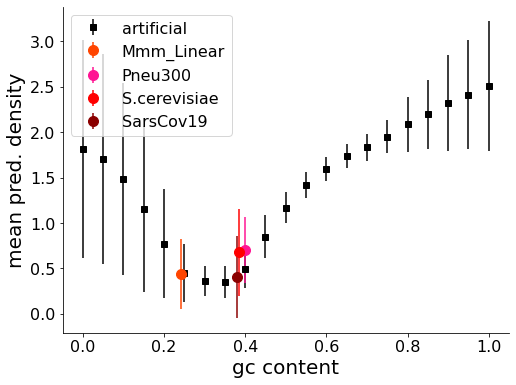

In [39]:
fig = plt.figure(figsize=(8, 6))

markersize = 10

ax = fig.add_subplot(1, 1, 1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.errorbar(np.arange(0, 1.05, 0.05),
            means,
            linestyle='',
            marker='s',
            yerr=stds,
            color='k',
            label='artificial')
ax.errorbar([get_gc_content('./data/bacterie/Mmm_Linear_740kb.hdf5')],
            [np.mean(np.concatenate([np.load('./results/bacterial/pol2_myco_2048_16.npy'),
                                     np.load('./results/bacterial/pol2_myco_2048_16_2.npy'),
                                     np.load('./results/bacterial/pol2_myco_2048_16_3.npy')]))],
             marker='o',
             markersize=markersize,
             linestyle='',
             yerr=[np.std(np.concatenate([np.load('./results/bacterial/pol2_myco_2048_16.npy'),
                                         np.load('./results/bacterial/pol2_myco_2048_16_2.npy'),
                                         np.load('./results/bacterial/pol2_myco_2048_16_3.npy')]))],
             color='orangered',
             label='Mmm_Linear')

ax.errorbar([get_gc_content('./data/bacterie/Pneu300.hdf5')],
            [np.mean(np.concatenate([np.load('./results/bacterial/pol2_pneu_2048_16.npy'),
                                     np.load('./results/bacterial/pol2_pneu_2048_16_2.npy'),
                                     np.load('./results/bacterial/pol2_pneu_2048_16_3.npy')]))],
             marker='o',
             markersize=markersize,
             linestyle='',
             yerr=[np.std(np.concatenate([np.load('./results/bacterial/pol2_pneu_2048_16.npy'),
                                          np.load('./results/bacterial/pol2_pneu_2048_16_2.npy'),
                                          np.load('./results/bacterial/pol2_pneu_2048_16_3.npy')]))],
             color='deeppink',
             label='Pneu300')

ax.errorbar([gc_content_yeast],
            [mean_coverage_yeast],
             marker='o',
             markersize=markersize,
             linestyle='',
             yerr=[std_coverage_yeast],
             color='red',
             label='S.cerevisiae')

ax.errorbar([get_gc_content('../Projet_nucleosomes/Programme/seq_chr_sacCer3/covid19/chr1.hdf5')],
            [np.mean(np.concatenate([np.load('./results/covid19/pol2_coverage.npy'),
                                     np.load('./results/covid19/pol2_coverage_2.npy'),
                                     np.load('./results/covid19/pol2_coverage_3.npy')]))],
             marker='o',
             markersize=markersize,
             linestyle='',
             yerr=[np.std(np.concatenate([np.load('./results/covid19/pol2_coverage.npy'),
                                          np.load('./results/covid19/pol2_coverage_2.npy'),
                                          np.load('./results/covid19/pol2_coverage_3.npy')]))],
             color='darkred',
             label='SarsCov19')
ax.legend(fontsize=16)
#ax.set_xticks(np.arange(0, 1.05, 0.2))
#ax.set_xticklabels(np.round(np.arange(0, 1.05, 0.2), 2), fontsize=16)

#ax.set_yticks(np.arange(-0.1, 0.31, 0.1))
#ax.set_yticklabels(np.round(np.arange(-0.1, 0.31, 0.1), 2), fontsize=16)
ax.set_xlabel('gc content', fontsize=20)
ax.set_ylabel('mean pred. density', fontsize=20)

fig.savefig('./results/gc_content_evolution_pol2_2048_16_3.png')

/users/invites/routhier/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
/users/invites/routhier/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/users/invites/routhier/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide
/users/invites/routhier/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/users/invites/routhier/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/users/invites/routhier/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/users/invites/routhier/anaconda3/envs/test_

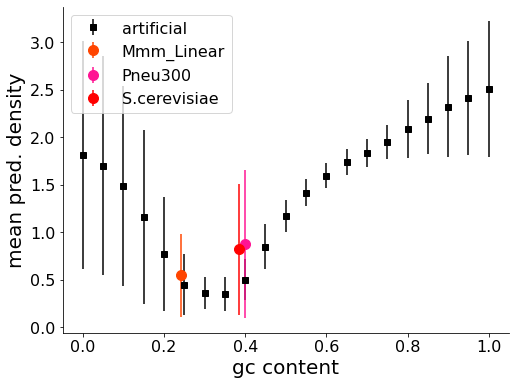

In [45]:
fig = plt.figure(figsize=(8, 6))

markersize = 10

ax = fig.add_subplot(1, 1, 1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.errorbar(np.arange(0, 1.05, 0.05),
            means,
            linestyle='',
            marker='s',
            yerr=stds,
            color='k',
            label='artificial')
ax.errorbar([get_gc_content('./data/bacterie/Mmm_Linear_740kb.hdf5')],
            [np.mean(log(myco_coverage_rep1['Mmm_Linear_740kb.fa'] / myco_coverage_rep2['Mmm_Linear_740kb.fa']))],
             marker='o',
             markersize=markersize,
             linestyle='',
             yerr=[np.std(log(myco_coverage_rep1['Mmm_Linear_740kb.fa'] / myco_coverage_rep2['Mmm_Linear_740kb.fa']))],
             color='orangered',
             label='Mmm_Linear')

ax.errorbar([get_gc_content('./data/bacterie/Pneu300.hdf5')],
            [np.mean(log(pneu_coverage_rep1['Pneu300'] / pneu_coverage_rep2['Pneu300']))],
             marker='o',
             markersize=markersize,
             linestyle='',
             yerr=[np.std(log(pneu_coverage_rep1['Pneu300'] / pneu_coverage_rep2['Pneu300']))],
             color='deeppink',
             label='Pneu300')

ax.errorbar([gc_content_yeast],
            [np.mean(np.concatenate([log(myco_coverage_rep1[chrom] / myco_coverage_rep2[chrom]) for chrom in ['chr01', 'chr02', 'chr03', 'chr04',
                                                                                                              'chr05', 'chr06', 'chr07', 'chr08', 'chr09', 'chr10',
                                                                                                              'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16']]))],
             marker='o',
             markersize=markersize,
             linestyle='',
             yerr=[np.std(np.concatenate([log(myco_coverage_rep1[chrom] / myco_coverage_rep2[chrom]) for chrom in ['chr01', 'chr02', 'chr03', 'chr04',
                                                                                                              'chr05', 'chr06', 'chr07', 'chr08', 'chr09', 'chr10',
                                                                                                              'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16']]))],
             color='red',
             label='S.cerevisiae')

ax.legend(fontsize=16)
ax.set_xlabel('gc content', fontsize=20)
ax.set_ylabel('mean pred. density', fontsize=20)
fig.savefig('./results/gc_content_evolution_pol2_experimental.png')

### For legacy

In [ ]:
from keras_dna import Generator, ModelWrapper
from keras_dna.model import load_wrapper
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K

from MyModuleLibrary.mykeras.losses import mae_cor, correlate
import os
import pyBigWig
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

inputs = tf.keras.layers.Input(shape=(2048, 4))

x = tf.keras.layers.Conv1D(32, 12, activation='relu', padding='same')(inputs)
x = tf.keras.layers.MaxPooling1D(8, padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Conv1D(32, 5, activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling1D(4, padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Conv1D(32, 5, activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling1D(4, padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Conv1D(16, 5, activation='relu', padding='same', dilation_rate=2)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)

x1 = tf.keras.layers.Conv1D(16, 5, activation='relu', padding='same', dilation_rate=4)(x)
x1 = tf.keras.layers.BatchNormalization()(x1)
x1 = tf.keras.layers.Dropout(0.2)(x1)

x2 = tf.keras.layers.Concatenate(axis=-1)([x, x1])
x2 = tf.keras.layers.Conv1D(16, 5, activation='relu', padding='same', dilation_rate=8)(x2)
x2 = tf.keras.layers.BatchNormalization()(x2)
x2 = tf.keras.layers.Dropout(0.2)(x2)

x3 = tf.keras.layers.Concatenate(axis=-1)([x, x1, x2])
x3 = tf.keras.layers.Conv1D(16, 5, activation='relu', padding='same', dilation_rate=16)(x3)
x3 = tf.keras.layers.BatchNormalization()(x3)
x3 = tf.keras.layers.Dropout(0.2)(x3)

x = tf.keras.layers.Concatenate(axis=-1)([x, x1, x2, x3])
outputs = tf.keras.layers.Conv1D(1, 1, activation='linear', padding='same')(x)

model = tf.keras.models.Model(inputs, outputs)
model.compile(optimizer='adam',
              sample_weight_mode='temporal',
              loss='mae',
              metrics=[correlate])

generator_train = Generator(batch_size=64,
                            fasta_file='./data/W303.fa',
                            annotation_files=['./data/myco_coverage_pol2_log_cpm.bw'],
                            size='./data/W303.chrom.sizes',
                            window=2048,
                            tg_window=16,
                            downsampling='mean',
                            overlapping=10,
                            weighting_mode=([[0, 1, 2, 3, 4, 5, 6, 10]],
                                            [[1, 4, 10, 20, 30, 40, 50]]),
                            incl_chromosomes=['chr01', 'chr02', 'chr03', 'chr04',
                                              'chr05', 'chr06', 'chr07', 'chr08', 'chr09', 'chr10',
                                              'chr11', 'chr12', 'chr13', 'chr14'],
                            output_shape=(64, 16, 1))

wrap = ModelWrapper(model=model,
                    generator_train=generator_train,
                    validation_chr=['chr15', 'chr16'],
                    weights_val=True)

early = keras.callbacks.EarlyStopping(monitor='val_loss',
                                      min_delta=0,
                                      patience=5,
                                      verbose=0,
                                      mode='auto')

checkpointer = keras.callbacks.ModelCheckpoint(filepath='./models/weights_myco_pol2_2048_16_3.hdf5',
                                               monitor='val_loss',
                                               verbose=0, 
                                               save_best_only=True, 
                                               save_weights_only=False, 
                                               mode='min',
                                               period=1)

history = wrap.train(epochs=100,
                     callbacks=[early, checkpointer],
                     verbose=1)

In [136]:
from keras_dna import Generator, ModelWrapper
from keras_dna.model import load_wrapper
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K

from MyModuleLibrary.mykeras.losses import mae_cor, correlate
import os
import pyBigWig
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

inputs = tf.keras.layers.Input(shape=(2000, 4))

x = tf.keras.layers.Conv1D(32, 12, activation='relu', padding='same')(inputs)
x = tf.keras.layers.MaxPooling1D(8, padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Conv1D(32, 5, activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling1D(4, padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Conv1D(32, 5, activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling1D(4, padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Flatten()(x)

outputs = tf.keras.layers.Dense(1, activation='linear')(x)

model = tf.keras.models.Model(inputs, outputs)
model.compile(optimizer='adam',
              sample_weight_mode='temporal',
              loss='mae',
              metrics=[correlate])

generator_train = Generator(batch_size=64,
                            fasta_file='./data/W303.fa',
                            annotation_files=['./data/coverage_pol2_gal_log_cpm.bw'],
                            size='./data/W303.chrom.sizes',
                            window=2000,
                            tg_window=1,
                            weighting_mode=([[0, 1, 2, 3, 4, 5, 6, 10]],
                                            [[1, 4, 10, 20, 30, 40, 50]]),
                            incl_chromosomes=['chr01', 'chr02', 'chr03', 'chr04',
                                              'chr05', 'chr06', 'chr07', 'chr08', 'chr09', 'chr10',
                                              'chr11', 'chr12', 'chr13', 'chr14'],
                            output_shape=(64, 1))

wrap = ModelWrapper(model=model,
                    generator_train=generator_train,
                    validation_chr=['chr15', 'chr16'],
                    weights_val=True)

early = keras.callbacks.EarlyStopping(monitor='val_loss',
                                      min_delta=0,
                                      patience=5,
                                      verbose=0,
                                      mode='auto')

checkpointer = keras.callbacks.ModelCheckpoint(filepath='./models/weights_gal_pol2_CNN2000.hdf5',
                                               monitor='val_loss',
                                               verbose=0, 
                                               save_best_only=True, 
                                               save_weights_only=False, 
                                               mode='min',
                                               period=1)

history = wrap.train(epochs=100,
                     callbacks=[early, checkpointer],
                     steps_per_epoch=30000,
                     validation_steps=6000,
                     verbose=1)

Epoch 1/100
1000/1000 [==============================] - 130s 130ms/step - loss: 6.2443 - correlate: 0.1059 - val_loss: 4.7868 - val_correlate: 0.2410
Epoch 2/100
  90/1000 [=>............................] - ETA: 1:39 - loss: 4.3648 - correlate: 0.1890

KeyboardInterrupt: 

In [2]:
from keras_dna import Generator, ModelWrapper
import tensorflow.keras as keras
import numpy as np
import pyBigWig
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import itertools

In [1]:
def read_bed(pathname):
    df = pd.read_csv(pathname, names=['chrom', 'start', 'stop', 'density'], sep='\t')
    coverages = dict()
    for chrom in df.chrom.unique():
        if chrom in chrom_size:
            local_df = df[df.chrom == chrom]
            coverage = np.zeros(chrom_size[chrom])
            
            for start, stop, density in zip(local_df.start.values, local_df.stop.values, local_df.density.values):
                coverage[start : stop] = density
            coverages[chrom] = coverage
    
    all_coverage = np.concatenate([coverage for _, coverage in coverages.items()])
    threshold = np.sum(all_coverage) / 1000000.
    
    for chrom, coverage in coverages.items():
        coverages[chrom] = coverage / threshold
    return coverages

In [4]:
yeast_sizes = pd.read_csv('./data/W303.chrom.sizes', sep='\t', names=['chr', 'size'])
yeast_sizes = {chrom : size for chrom, size in yeast_sizes.values}

myco_sizes = pd.read_csv('./data/bacterie/Mmm_Linear_740kb.chrom.sizes', sep='\t', names=['chr', 'size'])
myco_sizes = {chrom : size for chrom, size in myco_sizes.values}

pneu_sizes = pd.read_csv('./data/bacterie/Pneu300.chrom.sizes', sep='\t', names=['chr', 'size'])
pneu_sizes = {chrom : size for chrom, size in pneu_sizes.values}

In [5]:
chrom_size = pd.read_csv('./data/W303.chrom.sizes', sep='\t', names=['chrom', 'sizes'])
chrom_size = {chrom : size for chrom, size in zip(chrom_size.chrom.values, chrom_size.sizes.values)}
chrom_size['Mmm_Linear_740kb.fa'] = 1222199
chrom_size['Pneu300'] = 817946

In [71]:
inputs = read_bed('./data/for_Julien/myco/coverage_RPKM245.bed')
bias = read_bed('./data/for_Julien/myco/coverage_RPKM247.bed')

In [72]:
bw = pyBigWig.open('./data/coverage_pol2_gal_log_cpm.bw', 'w')
bw.addHeader([(chrom, size) for chrom, size in yeast_sizes.items()])

for chrom in yeast_sizes.keys():
    values = inputs[chrom] / bias[chrom]
    values[np.isnan(values)] = 0
    values[np.isinf(values)] = np.percentile(values, 99)
    bw.addEntries(chrom, 0, values=list(np.log2(values + 1)), span=1, step=1)
bw.close()

/users/invites/routhier/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/users/invites/routhier/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


In [76]:
chrom = 'chr16'

In [77]:
bw = pyBigWig.open('./data/coverage_pol2_gal_log_cpm.bw')
prediction = np.array(bw.values(chrom, 0, yeast_sizes[chrom]))
bw.close()